<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option("mode.copy_on_write", True)

import os
os.chdir("/Users/paytonrodman/projects/migraine_weather")

<h1>Creating a Map of Pressure Variation</h1>

In [5]:
def remove_outliers(df):
    """
    Processes a dataframe df to remove day with outlier measurements.

    :param pd.DataFrame df: A pandas dataframe. Should contain the following columns:
        - temp
        - rhum
        - prcp
        - wspd
        - pres
    :returns cleaned_df: A cleaned pandas dataframe
    """
    import pandas as pd
    
    # calculate dvar_per_hour
    vars = ["temp","rhum","prcp","wspd","pres"]
    dt = df.index.to_series().diff().dt.days*24. + df.index.to_series().diff().dt.seconds//3600

    cleaned_df = df.copy()
    for var in vars:
        df[f'd{var}_per_hour'] = df[f'{var}'].diff() / dt

        # determine IQR for dvar_per_hour
        statistics = df[f'd{var}_per_hour'].describe()
        q75 = statistics["75%"]
        q25 = statistics["25%"]
        intr_qr = q75 - q25
        maxq = q75 + (3*intr_qr)
        minq = q25 - (3*intr_qr)

        # Find outliers with >=2 variations outside 3 IQR
        outliers = df[(df[f'd{var}_per_hour'] < minq) | (df[f'd{var}_per_hour'] > maxq)];
        outliers['date'] = outliers.index.date;
        entry_counts = outliers['date'].value_counts();
        valid_dates = entry_counts[entry_counts > 1].index;
        outliers = outliers[outliers['date'].isin(valid_dates)];

        # drop outlier days from dataframe
        drop_dates = list(set(outliers.index.date))
        cleaned_df = cleaned_df[~pd.Series(cleaned_df.index.date).isin(drop_dates).values]

    return cleaned_df

def get_variation_frac(df, var):
    """
    Processes a dataframe df and returns only those entries with an hourly starttime and endtime
    that encapsulates the range defined by start and end.

    :param pd.DataFrame df: A pandas dataframe. Should contain the following columns:
        - hourly_start
        - hourly_end
    :returns: The number of days per year of high pressure variation.
    """
    import pandas as pd

    if var == "pres":
        thresh = 10.

    fdays_yearly = {}
    # loop over years
    for yname, ygroup in df.groupby(pd.Grouper(freq='Y')):
        if ygroup[var].isna().all():
            fdays_yearly[yname.year] = float('nan')
            continue
        if sum(ygroup[var].isna())>0.1*len(ygroup[var]):
            fdays_yearly[yname.year] = float('nan')
            continue

        ndays = 0
        # loop over days
        for dname, dgroup in ygroup.groupby(pd.Grouper(freq='D')):
            vrange = dgroup[var].max() - dgroup[var].min()
            if vrange >= thresh:
                ndays += 1

        frac_days = ndays/len(list(set(ygroup.index.date)))
        fdays_yearly[yname.year] = frac_days
    return fdays_yearly

In [7]:
import meteostat
from datetime import datetime

country_code = 'AU'
start = datetime(2000, 1, 1, 0, 0, 0)
end = datetime(2020, 12, 31, 23, 59, 59)

stations = meteostat.Stations().region(country_code).fetch()
stations = stations[(stations['hourly_start'].dt.year<=start.year) & (stations['hourly_end'].dt.year>=end.year)]

n_stations = len(stations)
current_n = 0
av_frac_var = []
for station_id in stations.index:
    current_n += 1
    station_name = stations[stations.index==station_id]['name'].iloc[0]
    print(f'\r{(current_n/n_stations)*100:.2f}%', end='', flush=True)
    
    df = meteostat.Hourly(station_id, start, end).fetch()
    # if all or many pressure measurements are NaN, skip
    if (df["pres"].isna().all()) | (len(df[df["pres"].isna()])>0.5*len(df["pres"])):
        av_frac_var.append(float('nan'))
        continue
    
    cleaned_df = remove_outliers(df)
    frac_var_yearly = get_variation_frac(cleaned_df, "pres")
    av_frac_var.append(sum(frac_var_yearly.values())/len(frac_var_yearly)) # average fraction of days with high variation per year
    
stations.insert(0, "frac_var", av_frac_var)
stations = stations.drop(stations[stations['frac_var'] == 'NaN'].index)
print(stations)



100.00%       frac_var                  name country region    wmo  icao  latitude  \
id                                                                            
94120       NaN        Darwin Airport      AU     NT  94120  YPDN  -12.4000   
94132       NaN    Katherine / Tindal      AU     NT  94132  YPTN  -14.4500   
94150  0.000436          Gove Airport      AU     NT  94150  YDGV  -12.3000   
94171       NaN              Scherger      AU    QLD  94171  YBWP  -12.6000   
94203       NaN           Broome Port      AU     WA  95202  YBRM  -18.0000   
...         ...                   ...     ...    ...    ...   ...       ...   
YHID0       NaN  Horn Island / Wasaga      AU    QLD   <NA>  YHID  -10.5864   
YKRY0       NaN   Kingaroy / Taabinga      AU    QLD   <NA>  YKRY  -26.5808   
YNAR0       NaN            Narrandera      AU    NSW   <NA>  YNAR  -34.7022   
YPJT0       NaN  Perth / Canning Vale      AU     WA   <NA>  YPJT  -32.0975   
YSWL0  0.075710   Stawell / Illawarra      AU

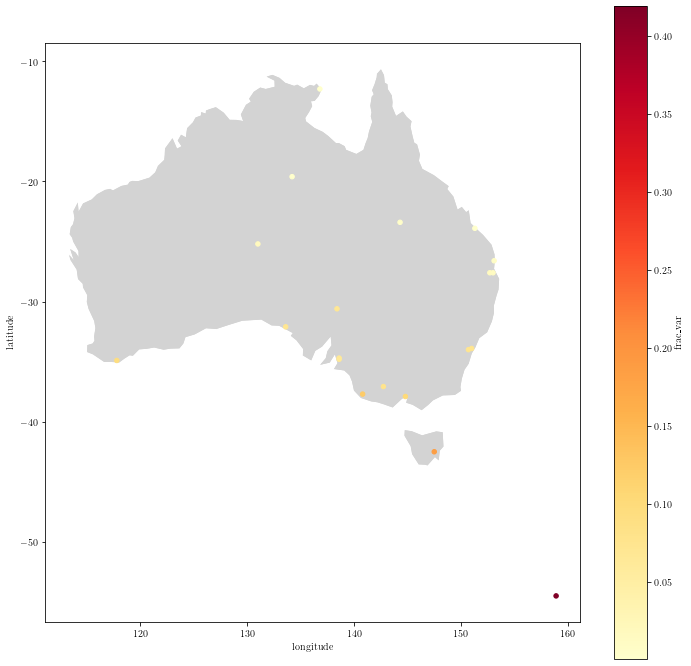

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

country_name = 'Australia'

# initialize an axis
fig, ax = plt.subplots(figsize=(12,12))
map_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
country_map = gpd.read_file(map_url)
country_map[country_map["NAME_EN"] == country_name].plot(color="lightgrey", ax=ax)
countries[countries["name"] == country_name].plot(color="lightgrey", ax=ax)

stations.plot(x="longitude", y="latitude", kind="scatter", c="frac_var", colormap="YlOrRd", ax=ax)
plt.show()